# Import packages
Note: This notebook can take a while (~5 min) for the first time due to compilation

In [7]:
from pyrms import rms
from diffeqpy import de
import numpy as np
import matplotlib.pyplot as plt
from julia import Main
%matplotlib inline

This notebook was originally created as a practice example for 2023 RMG workshop. 

In order to follow the notebook, you need to first run RMG-cat and generate the example mechanism under ``examples/rmg/catalysis/ch4_o2/input.py``. 

As a shortcut, you can generate the mechanism by removing the ``#`` in the following cell and running the cell; this may take quite a while. 

You may need to modify the path to make it consistent with your RMG installation path if you are not using RMG with Docker. 

For more details about the RMG-cat mechanisms, you can find links to the RMG workshop lectures at https://rmg.mit.edu/resources.

In [4]:
# ! python /rmg/RMG-Py/rmg.py /rmg/RMG-Py/examples/rmg/catalysis/ch4_o2/input.py

## Load the mechanism 
<p style="color: red;"> [User input required] </p>

Load the mechanism file from a `.rms` file
```
phase_dict = rms.readinput("/rmg/RMG-Py/examples/rmg/catalysis/ch4_o2/chem41.rms")
```
where `mechanism_path` is the path to the generated rms input file

P.S. The same function also works for chemkin files (with thermochemistry and kinetics in the same file):

```
phase_dict = rms.readinput("/rmg/RMG-Py/examples/rmg/catalysis/ch4_o2/chemkin/chem_annotated.inp"; 
                           spcdict="/rmg/RMG-Py/examples/rmg/catalysis/ch4_o2/chemkin/species_dictionary.txt")
```

Because RMS simulates gas-catalyst system as a gas phase and a surface explicitly, there are gas-phase species and reactions,

```
gas_spcs = phase_dict["gas"]["Species"];
gas_rxns = phase_dict["gas"]["Reactions"];
```

surface species and reactions,

```
surface_spcs = phase_dict["surface"]["Species"]
surface_rxns = phase_dict["surface"]["Reactions"]
```

and reactions that involve both gas phase and surface species,

```
interface_rxns = Main.get(phase_dict, Main.Set(["surface", "gas"]), Main.nothing)["Reactions"]
```

Note that we are using the dictionary getter ``Main.get`` to get the reactions under the surface and gas set ``Main.Set(["surface", "gas"])`` in the phase dictionary ``phase_dict``, and we specify it to return nothing ``Main.nothing`` if the set does not exist in the phase dictionary. 

In [33]:
mechanism_path = "ch4o2cat.rms"  # You may change the path to actual mechanism file path

phase_dict = rms.readinput(mechanism_path)
gas_spcs = phase_dict["gas"]["Species"]
gas_rxns = phase_dict["gas"]["Reactions"]
surface_spcs = phase_dict["surface"]["Species"]
surface_rxns = phase_dict["surface"]["Reactions"]
interface_rxns = Main.get(phase_dict, Main.Set(["surface", "gas"]), Main.nothing)["Reactions"]
print(f"{len(gas_spcs)} Gas-phase species")
print(f"{len(gas_rxns)} Gas-phase reactions")
print(f"{len(surface_spcs)} Surface species")
print(f"{len(surface_rxns)} Surface reactions")
print(f"{len(interface_rxns)} Gas-Surface reactions")

12 Gas-phase species
3 Gas-phase reactions
29 Surface species
198 Surface reactions
21 Gas-Surface reactions


## Change simulation inputs here
<p style="color: red;"> [User input required] </p>

`gas_initial_conds`: a dictionary containing the initial conditions for gas phase, where
- `T`: temperature (K)
- `P`: pressure (Pa)
- `O2`: number of moles of O2
- `N2`: number of moles of N2
- `CH4`: number of moles of CH4

`surface_initial_conds`: a dictionary containing the initial conditions for surface phase, where
- `T`: temperature (K)
- `A`: area (m^2)
- `vacantX`: initial surface vacancies

`tspan`: the simulation time span ($t_0$, $t_f$) in second. E.g., `(0.0, 1.0)` in this example stands for simulating from 0 to 0.1 second

In [34]:
T = 800.0
P = 1.0e5
A = 6651.2
site_density = 2.486e-5

gas_initial_conds = {
    "T": T,
    "P": P,
    "O2": 0.2,
    "N2": 0.7,
    "CH4": 0.1
}

surface_initial_conds = {
    "T": T,
    "A": A,
    "vacantX": site_density*A,
}
tspan = (0.0, 0.1)

## Set up and Run the simulation
### Make the ideal gas phase
[No User input required]

`Phase` controls how the thermochemical and kinetic properties are calculated. 

In this example, we are using `IdealGas` for the gas phase and assume treating the gas phase as ideal gases, and we are using `IdealSurface` for the catalyte and assume the surface can be treated as ideal surface.

In [35]:
ig = rms.IdealGas(gas_spcs, gas_rxns, name="gas")
cat = rms.IdealSurface(surface_spcs, surface_rxns, site_density, name="surface")

### Set up the domain
[No User input required]

Domain controls the assumptions made in the simulation (e.g., isothermal, isobaric, adiabatic, etc.)

`ConstantTPDomain`: assuming homogeneous constant temperature and constant volume gas phase system. The input is the `Phase` and gas phase initial conditions. The output `domaingas` is the gas phase domain (used to create reactor), `y0gas` the array of gas phase initial mole, `pgas` the (thermo/kinetic) parameters used of the system

`ConstantTAPhiDomain`: assuming homogeneous constant temperature and constant area surface system. The input is the `Phase` and initial conditions. The output `domaincat` is the domain (used to create reactor), `y0cat` the array of initial mole, `pcat` the (thermo/kinetic) parameters used of the system

In [36]:
domaingas, y0gas, pgas = rms.ConstantTPDomain(phase=ig, initialconds=gas_initial_conds)
domaincat, y0cat, pcat = rms.ConstantTAPhiDomain(phase=cat, initialconds=surface_initial_conds)

### Set up the reactive interface
[No User input required]

Reactive interface contains reactions that involve species in two different domains.

`ReactiveInternalInterfaceConstantTPhi`: assuming constant temperature, constant potential and constant area. The output `inter` is the interface (used to create reactor), `pinter` the (thermo/kinetic) parameters for the interphase reactions.

In [37]:
inter, pinter = rms.ReactiveInternalInterfaceConstantTPhi(domaingas, domaincat, interface_rxns, T, A)

### Set up the reactor
[No User input required]

In this step, the ordinary differential equations (ODEs) of the system will be constructed based on the defined domains, initial conditions, and parameters.

In [38]:
react, y0, p = rms.Reactor((domaingas,domaincat),(y0gas, y0cat), tspan, (inter,), (pgas, pcat, pinter))

### Solve the ODEs
<p style="color: red;"> [User input optional] </p>

The constructed ODEs will be solved. In this 

In [39]:
sol = de.solve(react.ode,
               de.CVODE_BDF(),  # You may use a different ODE solver. This is the one also used in Cantera
               abstol=1e-20,  # You may tighter the tolerance with a cost of more computational time
               reltol=1e-8,  # You may tighter the tolerance with a cost of more computational time
               )

### Set up System Simulation object
[No User input required]

Gathering the multi-phase simulation results and make it ready to be read, output, and visualized

In [40]:
ssys = rms.SystemSimulation(sol, (domaingas,domaincat,), (inter,), p);

# Analyze simulation results here

## Plot mole fractions of surface species as a function of time
<p style="color: red;"> [User input optional] </p>

Plot mole fractions of surface species as a function of time between specified time. You may change the following parameters
- `tf`: final time point to plot (in second)
- `tol`: include the species if its mole fraction is above the tolerance any point in time

To plot the mole fractions of a set of specific species, use ``rms.plotmolefractions(ssys.sims[1], spcnames)``, where
- `spcnames`: specify the species to include in the plot

Text(0, 0.5, 'Mole Fraction')

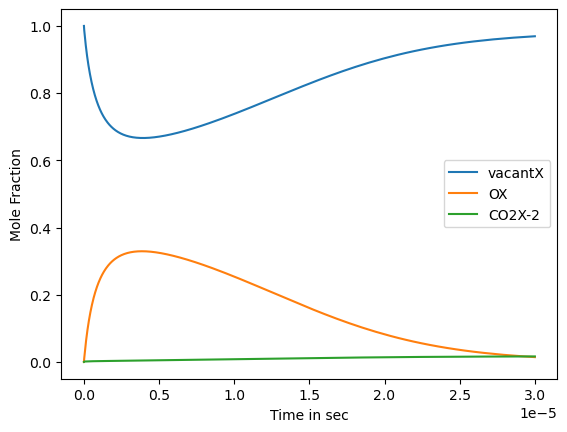

In [45]:
tf = 3e-5
tol = 1e-3
rms.plotmolefractions(ssys.sims[1], tf, tol=tol)

## Plot mole fractions of gas phase species as a function of time
<p style="color: red;"> [User input optional] </p>

Plot mole fractions of gas phase species as a function of time between specified time. You may change the following parameters
- `tf`: final time point to plot (in second)
- `tol`: include the species if its mole fraction is above the tolerance any point in time

Text(0, 0.5, 'Mole Fraction')

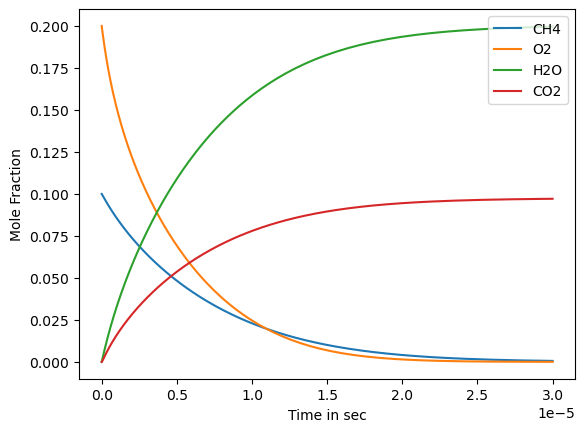

In [46]:
tf = 3e-5
tol = 1e-2
rms.plotmolefractions(ssys.sims[0], tf, exclude=["N2"], tol=tol)

## Plot flux diagram
<p style="color: red;"> [User input optional] </p>

Plot flux diagram at time `t` in seconds. You can try different values of `t` between `tspan` you defined 

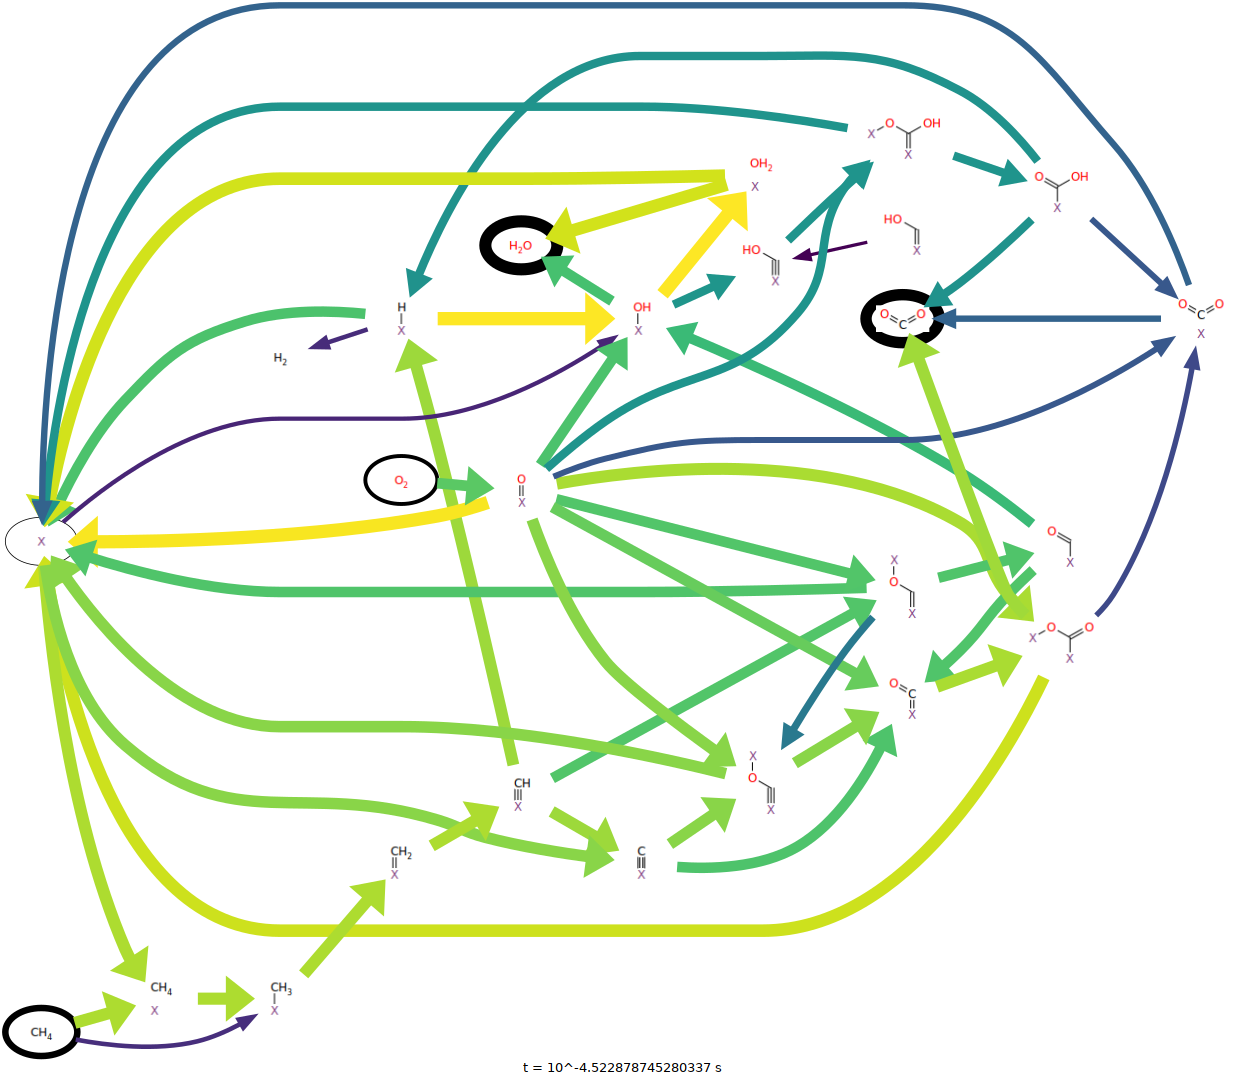

In [49]:
t = 3e-5
rms.getfluxdiagram(ssys, t)

## Plot ROPs
<p style="color: red;"> [User input optional] </p>

Plot ROPs for specified species at specified time. You can 
- `t`: Plot ROPs at time t (in second). Should be between `tspan`.
- `spc`: The label of the species you want to plot ROP for. (e.g., `OX` in this example)

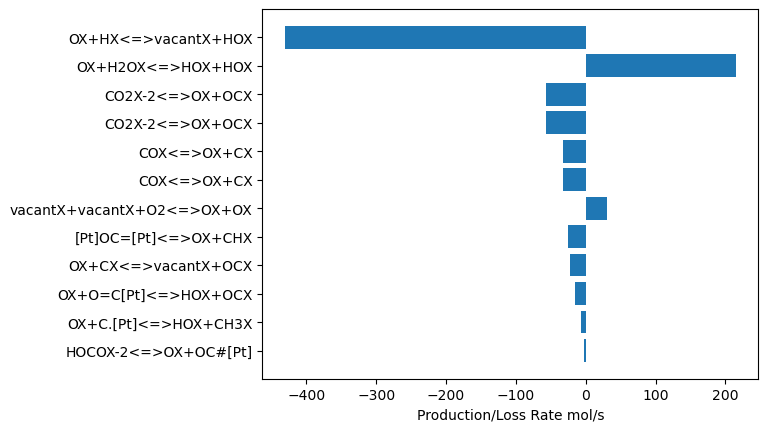

In [51]:
t = 3e-5
spc = "OX"
rms.plotrops(ssys, spc, t)

## Next step

This notebook was originally created as a practice example for 2023 RMG workshop. 

For more details about the RMG-cat mechanisms, you can find links to the RMG workshop lectures at https://rmg.mit.edu/resources.